In [467]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import make_classification

In [468]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.7.0


In [448]:
def make_spirals(n_samples, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_samples,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_samples,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_samples,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_samples),np.ones(n_samples))))

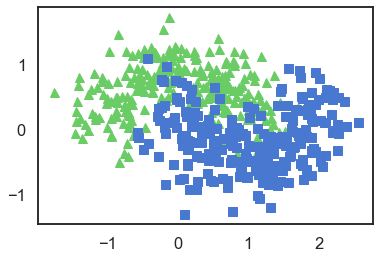

In [513]:
from sklearn import datasets
no = .3
X, y = datasets.make_moons(n_samples=500, noise=no)#, centers=2, n_features=2, center_box=(0, 10))
#X1, y1 = datasets.make_moons(n_samples=200, noise=no)
#X11 = np.array([[x + 2, yy] for x, yy in X1])
#X = np.concatenate((X, X11), axis=0)
#y = np.concatenate((y, y1), axis=0)
#print(X.shape)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

len train: 400
len test: 100


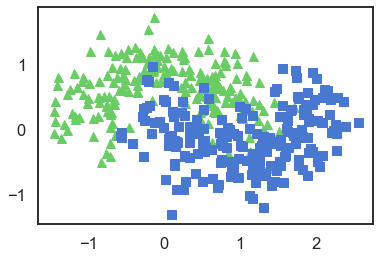

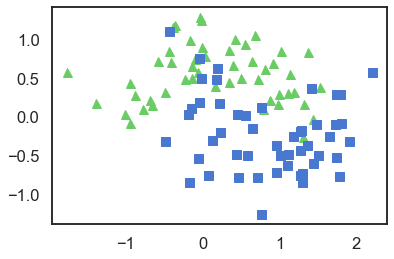

In [514]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)
print('len train:', len(X_train))
print('len test:', len(X_test))
plt.plot(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], 'g^')
plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], 'bs')
plt.show()
plt.plot(X_test[:, 0][y_test == 0], X_test[:, 1][y_test == 0], 'g^')
plt.plot(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], 'bs')
plt.show()

In [515]:
BATCH_SIZE = 32
n_features = 2
training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).float())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).float())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Define accuracy & Model

In [516]:
def accuracy(model, test_loader, l=200):
    correct = 0
    losses = []
    for examples, labels in test_loader:
        output = model.forward(examples)
        batch_correct = torch.sum(torch.abs(torch.flatten(output) - labels) < 0.5)
        losses.append(nn.BCELoss()(torch.flatten(output), labels))
        correct += batch_correct

    acc = float(correct)/l
    loss = sum(losses)/len(losses)
    return acc, loss

def accuracy_per_data(model, inputs, labels):
    inp = Variable(inputs, requires_grad=True)
    outputs = model.forward(inp)
    loss = nn.BCELoss()(torch.squeeze(outputs), labels)
    correct = torch.sum(torch.abs(torch.flatten(outputs) - labels) < 0.5)
    return correct/len(inputs), loss

In [517]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
           nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

# The calculation for immediate sensitivity

In [518]:
def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
    loss = criterion(torch.squeeze(outputs), labels)
    
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    
    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p = 2)
    
    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
    
    # (4) L2 norm of (3) - "immediate sensitivity"
    s = [torch.norm(v, p=2).numpy().item() for v in sensitivity_vec]
    
    '''
    if epoch > 5:
        print(f"inputs: ",inp)
        print(f"outputs: ", outputs)
        print(f"loss: ", loss)
        print(f"first_order_grads: ", first_order_grads)
        print(f"grad_l2_norm:: ", grad_l2_norm)
        print(f"sensitivity_vec: ", sensitivity_vec)
        print(f"sensitivies: ", s)
    '''

    loss.backward()
    return loss, s

In [519]:
def plot_decision_boundary(model, loss, steps=1000, cmap='Paired', title=None):
    cmap = plt.get_cmap(cmap)
    #torch.abs(torch.flatten(output) - labels) < 0.5

    xmin, xmax = -10, 10
    ymin, ymax = -10, 10
    # Define region of interest by data limits
    #     xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    #     ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    mesh_examples = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    labels = model.forward(mesh_examples) < 0.5

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape).detach().numpy()

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # get sensitivities of the data
    _, sensitivities = grad_immediate_sensitivity(model, 
                                                  loss, 
                                                  torch.from_numpy(X).float(), 
                                                  torch.from_numpy(y).float(), 
                                                  None)
    max_sen = max(sensitivities)
    norm_sen = [s/max_sen for s in sensitivities]
    min_exp = min([np.log(s) for s in sensitivities if s != 0])
    log_sen = [np.log(s) if s !=0 else min_exp - 1 for s in sensitivities]
    paws = [s - (min_exp - 1) for s in log_sen]

    
    # Get predicted labels on training data and plot
    train_labels = model.forward(torch.from_numpy(X).float())
    #ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)
    #ax.scatter(X[:,0], X[:,1], s=30000*(np.array(sensitivities)), c=sensitivities, cmap='binary', lw=0)
    ax.scatter(X[:,0], X[:,1], c=norm_sen, cmap='binary', lw=0)
    fig.colorbar(cm.ScalarMappable(norm=None, cmap='binary'),ax=ax)
    
    if title != None:
        plt.title(title)

    return fig, ax

# Train the model, calculating immediate sensitivities

In [520]:
def run_experiment(epsilon):
    # reset the model
    model = Classifier(n_features=n_features)
    model_criterion = nn.BCELoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 750
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 25
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []
    train_accs = []
    test_losses = []
    all_batch_mean_sensitivities = []
    all_batch_max_sensitivities = []

    for epoch in range(epochs):
#         print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            train_losses.append(loss)
            
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
            all_sensitivities.extend(batch_sensitivities)
            all_batch_mean_sensitivities.append(np.mean(batch_sensitivities) / BATCH_SIZE)
            all_batch_max_sensitivities.append(np.max(batch_sensitivities) / BATCH_SIZE)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)

#             with torch.no_grad():
#                 for p in model.parameters():
#                     p.grad += (sigma * torch.randn(1).float())

            model_optimizer.step()

        max_sensitivities.append(np.max(all_sensitivities))
        mean_sensitivities.append(np.mean(all_sensitivities))
        max_sigmas.append(np.max(sigmas))        
        mean_sigmas.append(np.mean(sigmas))
        train_accs.append(accuracy_per_data(model, torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()))
        test_accs.append(accuracy_per_data(model, torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()))
        
        
        #plot_decision_boundary(model, nn.BCELoss(), steps=100, title=f'Epoch {epoch}')
        
#         print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
#         print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
#         print("Max sigma for the epoch:", max_sigmas[-1])
#         print("Mean sigma for the epoch:", mean_sigmas[-1])

#         print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, 
                                          mean_sigmas, test_accs, train_accs,
                                          all_batch_mean_sensitivities, all_batch_max_sensitivities, test_losses), model

In [521]:
final_acc, info_tuple, model = run_experiment(100.1)
print("Final accuracy:", final_acc[0])

Final accuracy: 0.415


## Decision Boundary

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

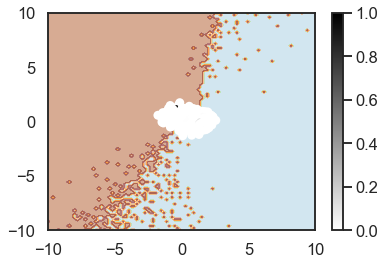

In [522]:
plot_decision_boundary(model, nn.BCELoss(), steps=100)

# IS does *NOT* Increase Per Batch

9000
9000


Text(0, 0.5, 'Mean Sensitivity')

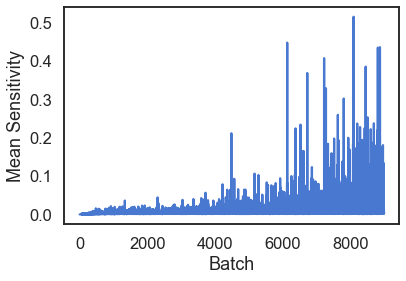

In [523]:
#the info tuple holds: (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, all_means)
batch_mean_sensitivities = info_tuple[7]
batch_max_sensitivities = info_tuple[8]
print(len(batch_max_sensitivities))
print(len(batch_mean_sensitivities))

plt.plot(batch_mean_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Mean Sensitivity")

Text(0, 0.5, 'Max Sensitivity')

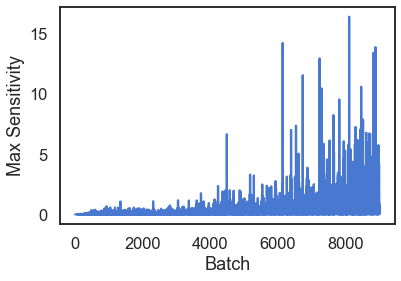

In [524]:
plt.plot(batch_max_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Max Sensitivity")

# IS *DOES* Increase Per Epoch

Text(0, 0.5, 'Max Sensitivity')

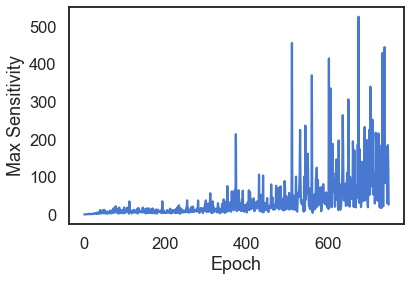

In [525]:
plt.plot(info_tuple[1])
plt.xlabel("Epoch")
plt.ylabel("Max Sensitivity")

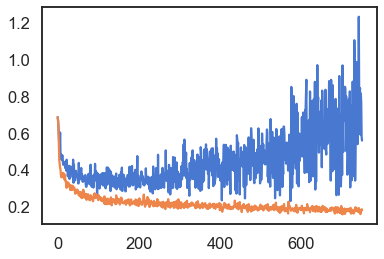

In [526]:
test_accs = info_tuple[5]
train_accs = info_tuple[6]
test_a, test_l = zip(*test_accs)
train_a, train_l = zip(*train_accs)
plt.plot(test_l)
plt.plot(train_l)

In [566]:
avg_train_l = sum(train_l)/len(train_l)
avg_test_l = sum(test_l)/len(test_l)
avg_train_a = sum(train_a)/len(train_a)
avg_test_a = sum(test_a)/len(test_a)
avg_train_l, avg_test_l, avg_train_a, avg_test_a


(tensor(0.2171, grad_fn=<DivBackward0>),
 tensor(0.4493, grad_fn=<DivBackward0>),
 tensor(0.9185),
 tensor(0.8759))

# Membership Inference Attacks

In [575]:
def gaussian_pdf(sd, x):
    if sd <= 0:
        raise ValueError('standard deviation must be positive but is {}'.format(sd))
    else: #sd > 0
        return np.e ** (-0.5*(x/sd)**2) / sd


def membership_inf(model, avg_train_loss, inputs, labels):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
    loss = nn.BCELoss(reduction='none')(torch.squeeze(outputs), labels)
    pass_inf = [1 if abs(l) < avg_train_loss*.1 else 0 for l in loss]
    
    return pass_inf, [float(l) for l in loss]

positive ratio on training data  0.515


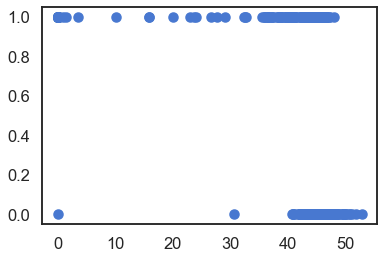

In [578]:
_, sensitivities = grad_immediate_sensitivity(model, 
                                                  nn.BCELoss(), 
                                                  torch.from_numpy(X_train).float(), 
                                                  torch.from_numpy(y_train).float(), 
                                                  None)
max_sen = max(sensitivities)
norm_sen = [s/max_sen for s in sensitivities]
min_exp = min([np.log(s) for s in sensitivities if s != 0])
log_sen = [np.log(s) if s !=0 else min_exp - 1 for s in sensitivities]
paws = [s - (min_exp - 1) for s in log_sen]

pass_inf, train_loss = membership_inf(model, avg_train_l, torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
plt.scatter(paws, pass_inf)
print('positive ratio on training data ',sum(pass_inf)/len(pass_inf))

positive ratio on test data  0.49


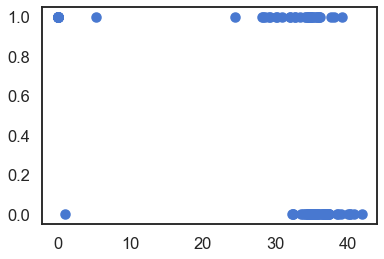

In [579]:
_, sensitivities = grad_immediate_sensitivity(model, 
                                                  nn.BCELoss(), 
                                                  torch.from_numpy(X_test).float(), 
                                                  torch.from_numpy(y_test).float(), 
                                                  None)
max_sen = max(sensitivities)
norm_sen = [s/max_sen for s in sensitivities]
min_exp = min([np.log(s) for s in sensitivities if s != 0])
log_sen = [np.log(s) if s !=0 else min_exp - 1 for s in sensitivities]
paws = [s - (min_exp - 1) for s in log_sen]

pass_inf, test_loss = membership_inf(model, avg_train_l, torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
plt.scatter(paws, pass_inf)
print('positive ratio on test data ',sum(pass_inf)/ len(pass_inf))

Text(0.5, 0, 'Loss')

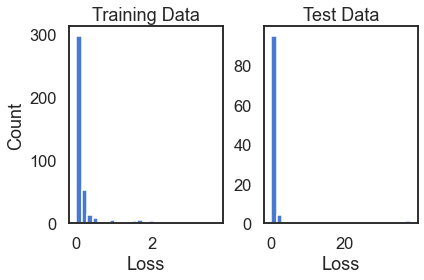

In [565]:

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist(train_loss, 25)
axs[0].title.set_text('Training Data')
axs[0].set_xlabel('Loss')
axs[0].set_ylabel('Count')
axs[1].hist(test_loss, 25, alpha=1)
axs[1].title.set_text('Test Data')
axs[1].set_xlabel('Loss')

# Accuracy Increases as Epsilon Increases

(as expected)

/Users/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyboardInterrupt: 

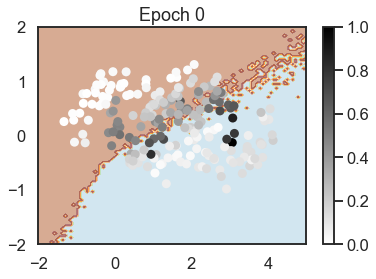

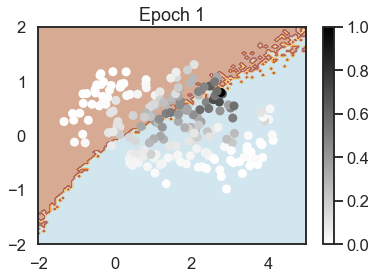

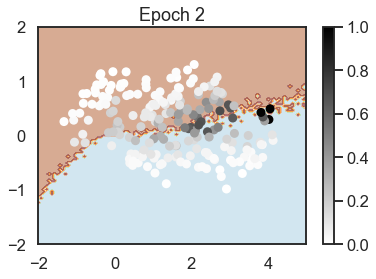

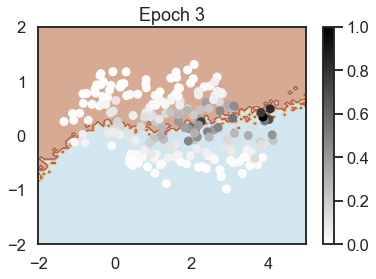

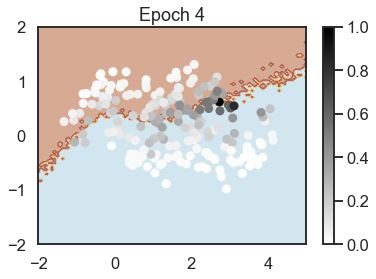

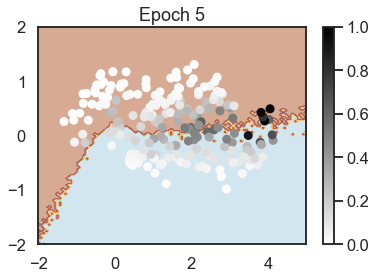

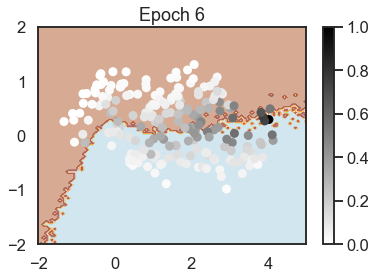

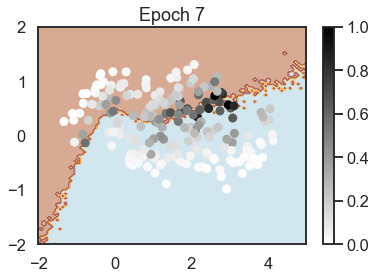

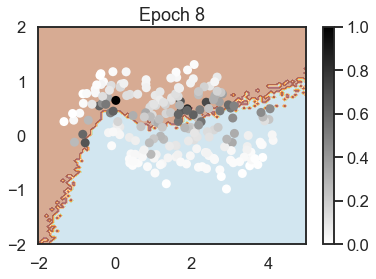

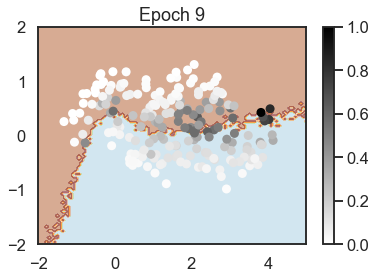

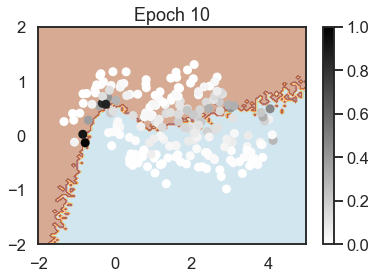

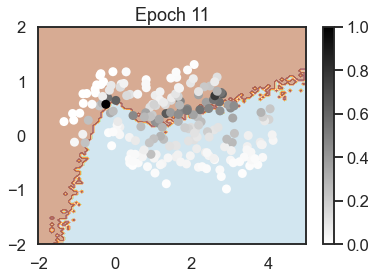

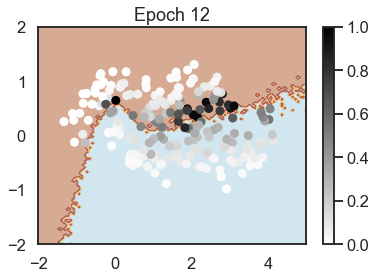

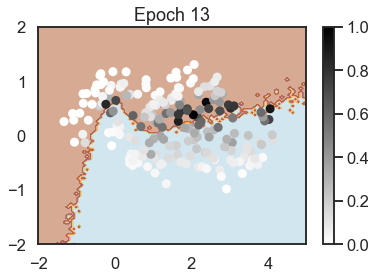

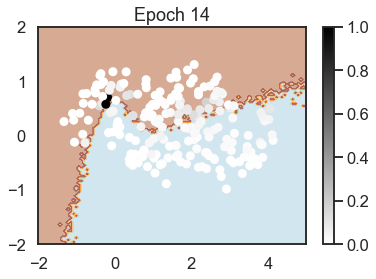

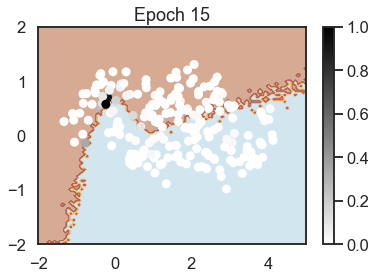

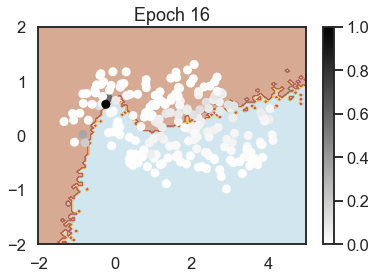

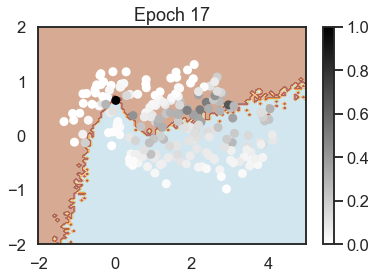

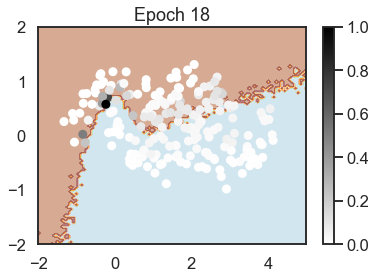

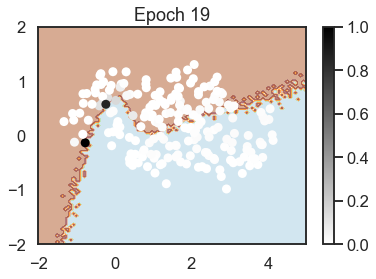

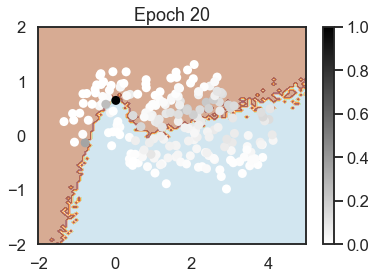

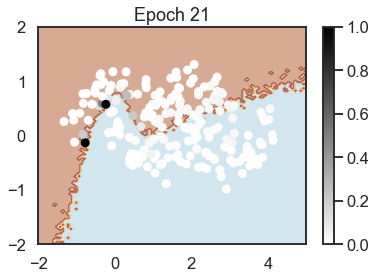

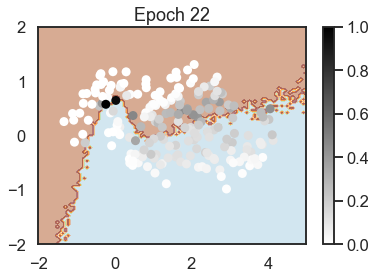

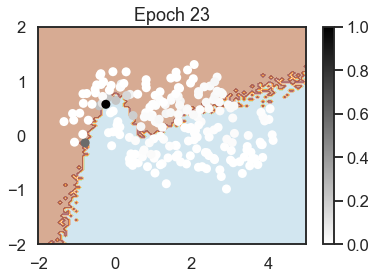

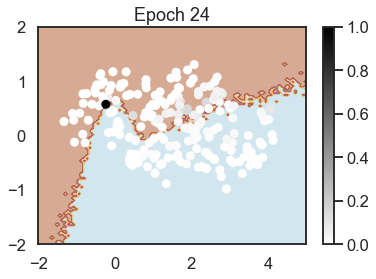

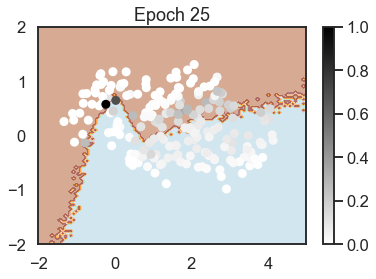

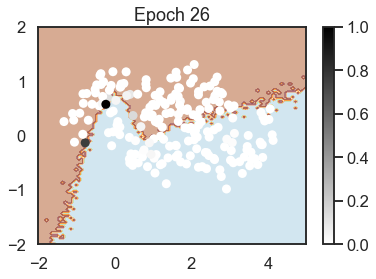

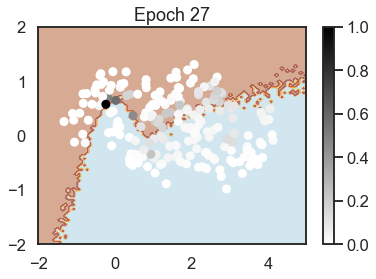

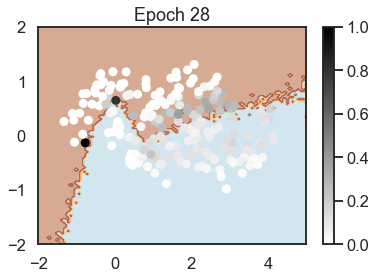

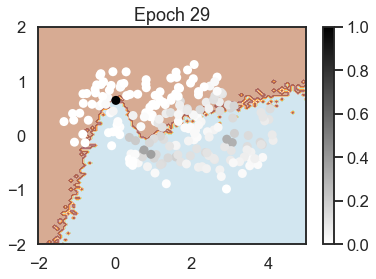

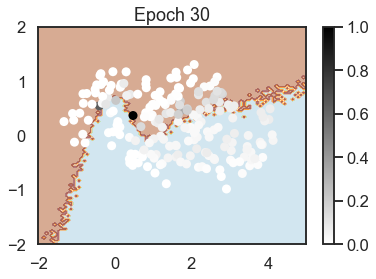

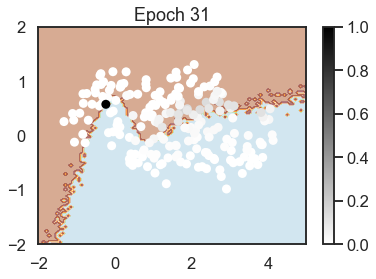

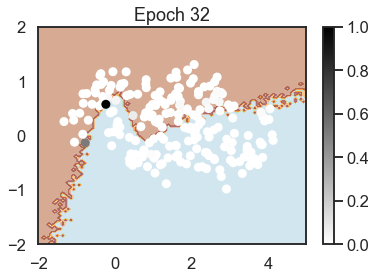

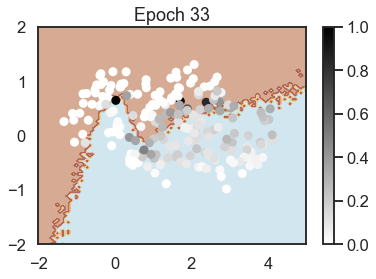

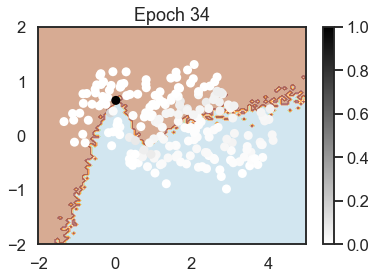

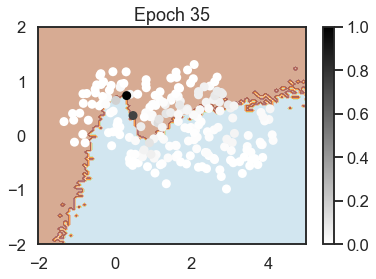

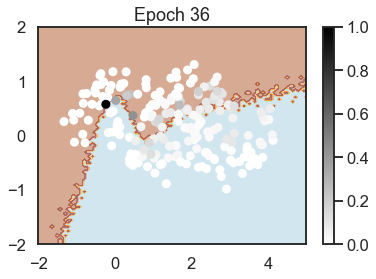

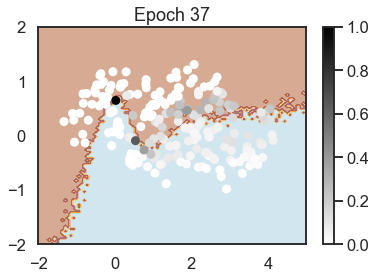

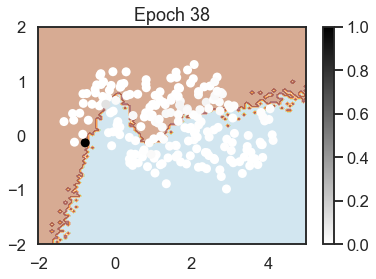

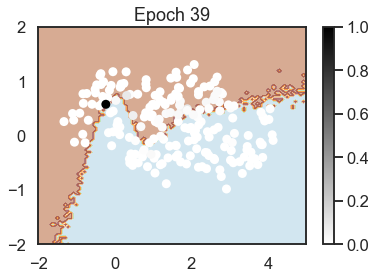

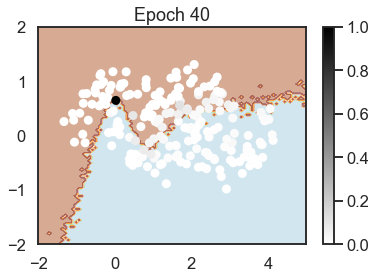

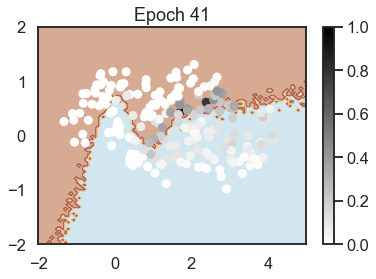

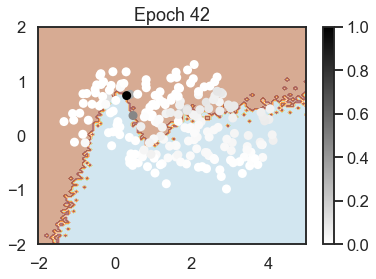

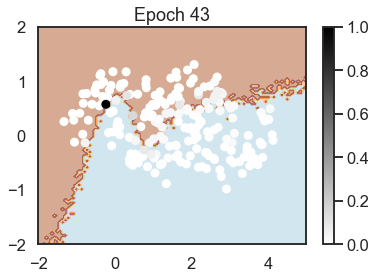

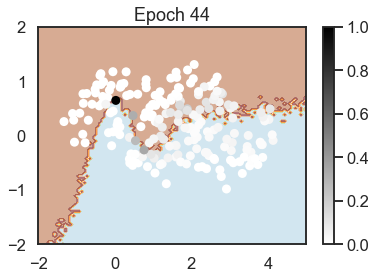

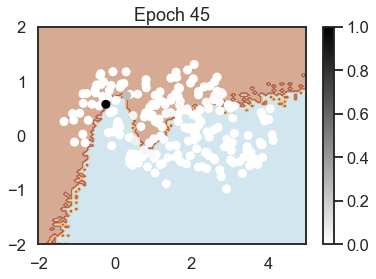

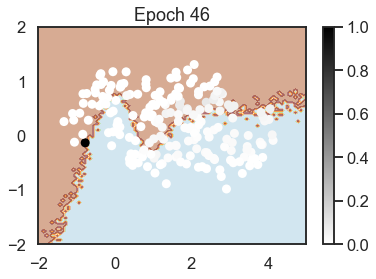

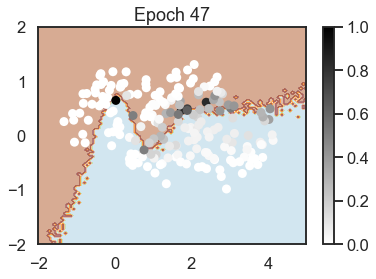

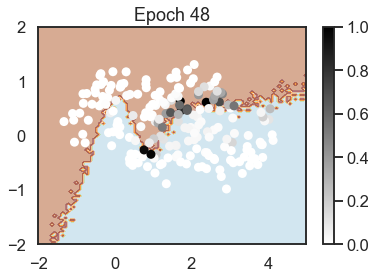

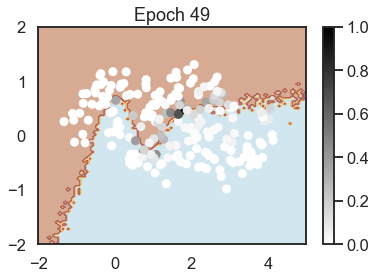

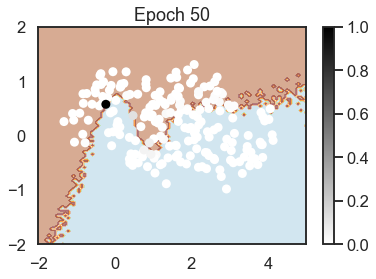

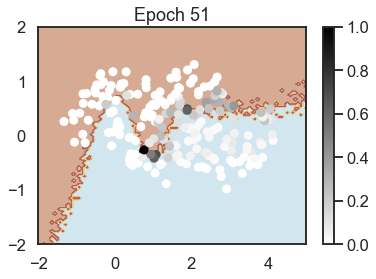

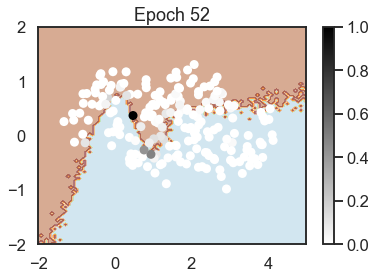

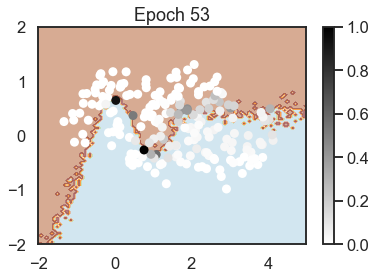

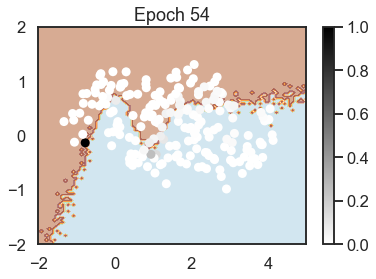

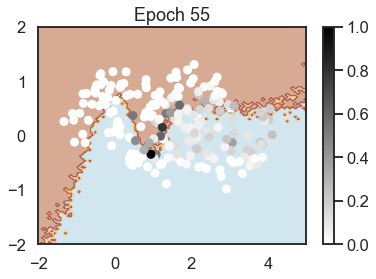

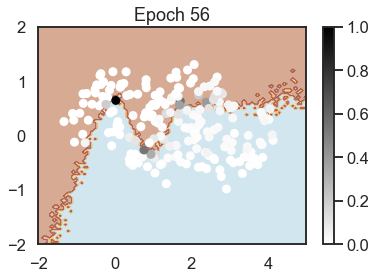

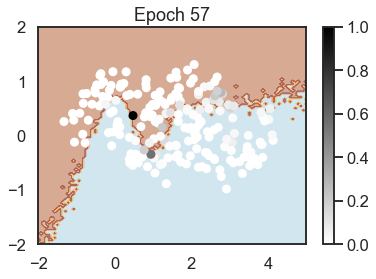

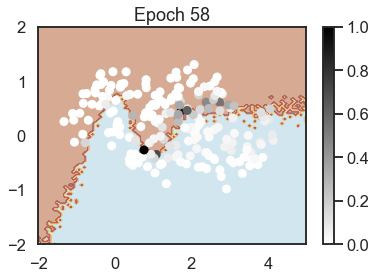

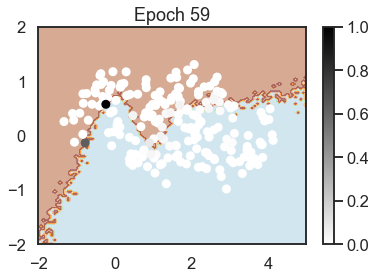

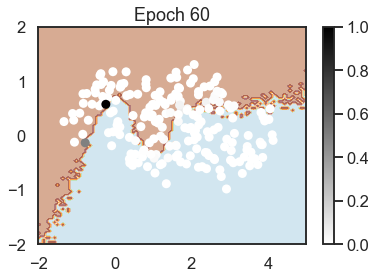

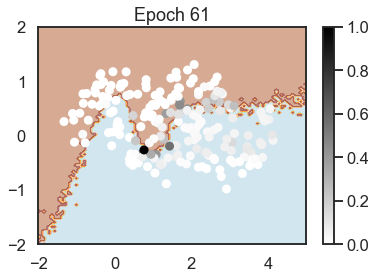

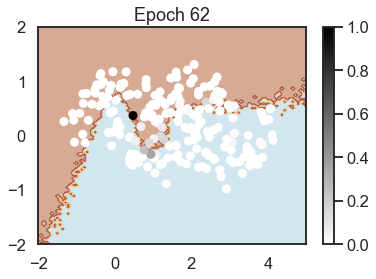

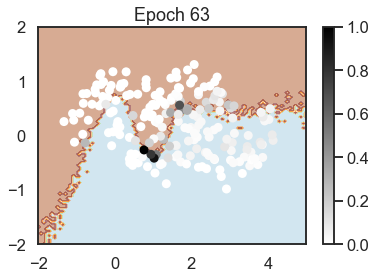

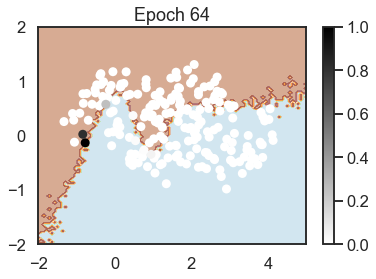

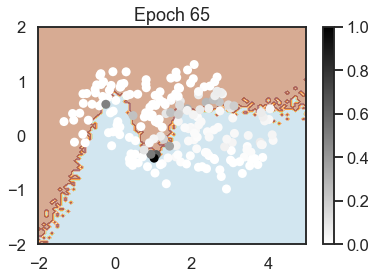

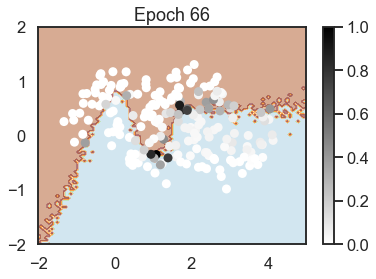

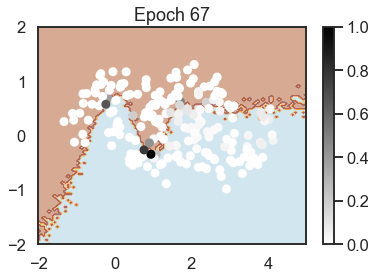

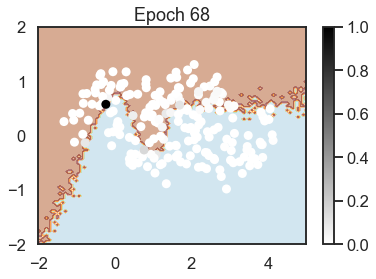

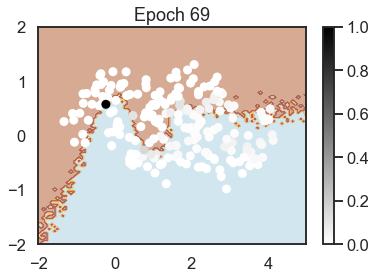

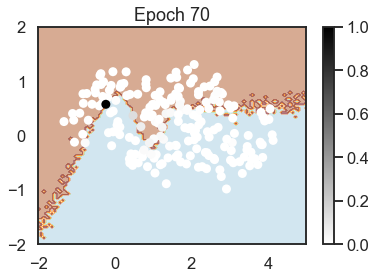

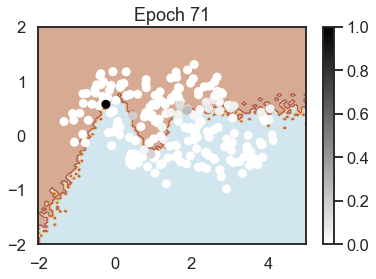

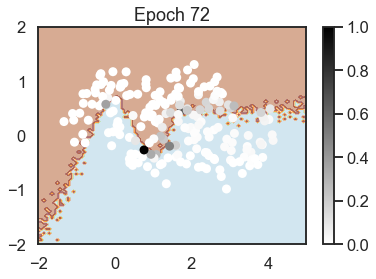

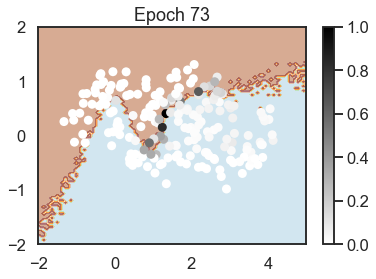

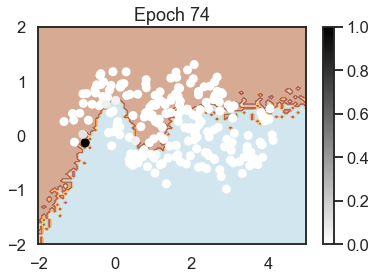

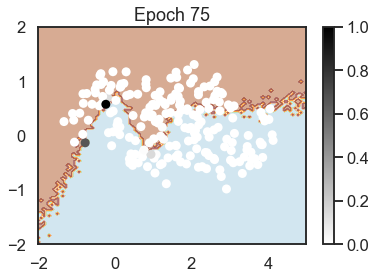

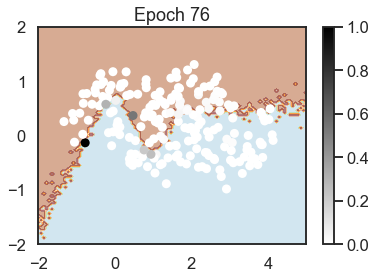

Error in callback <function flush_figures at 0x7faa7158f4d0> (for post_execute):


KeyboardInterrupt: 

In [78]:
accuracies = []
epsilons = [0.01, 0.1, 1.0, 10.0]

for epsilon in epsilons:
    accuracies.append(np.mean([run_experiment(epsilon)[0][0] for _ in range(5)]))

In [ ]:
plt.plot(epsilons, accuracies)
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')